# A demonstration of oslo_method_python


Before this notebook is run on a new system, make sure to compile the Cython files by doing (in the top repo directory):

```python setup.py build_ext --inplace```

In [91]:
%load_ext autoreload
import matplotlib.pyplot as plt
import numpy as np
import sys, os
import ompy as om
import logging
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
# Import raw matrix into instance of om.Matrix() and plot it
raw = om.load_example_raw('Dy164')
raw.cut_diagonal((800, 0), (7500, 7300))
raw.cut_rect(axis='Ex', limits=[0, 8400])
#raw.plot()

  warning.warn("Hello from the fill_negative() function. Please debug me.")



<IPython.core.display.Javascript object>


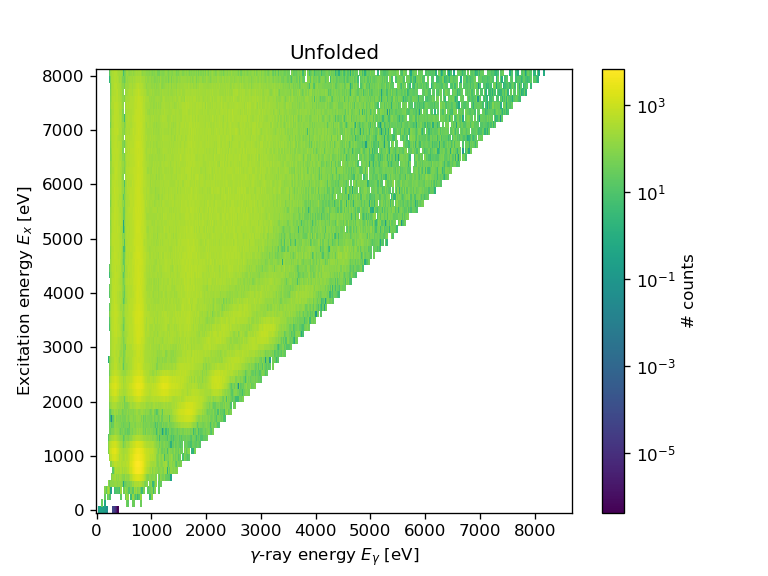

In [93]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("ompy.unfolder")
logger.setLevel(logging.INFO)

fname_resp_mat = "../data/Dy164_response_matrix.m"
fname_resp_dat = "../data/Dy164_response_parameters.dat"

unfolder = om.Unfolder(raw)
unfolder.load_response(fname_resp_mat)
unfolder.make_mask([800, 0], [7500, 7300])
unfolded = unfolder.unfold()
unfolded.fill_negative(window_size=10)
unfolded.remove_negative()
unfolded.plot()

  matrix_out = np.copy(matrix)



68 450


<IPython.core.display.Javascript object>


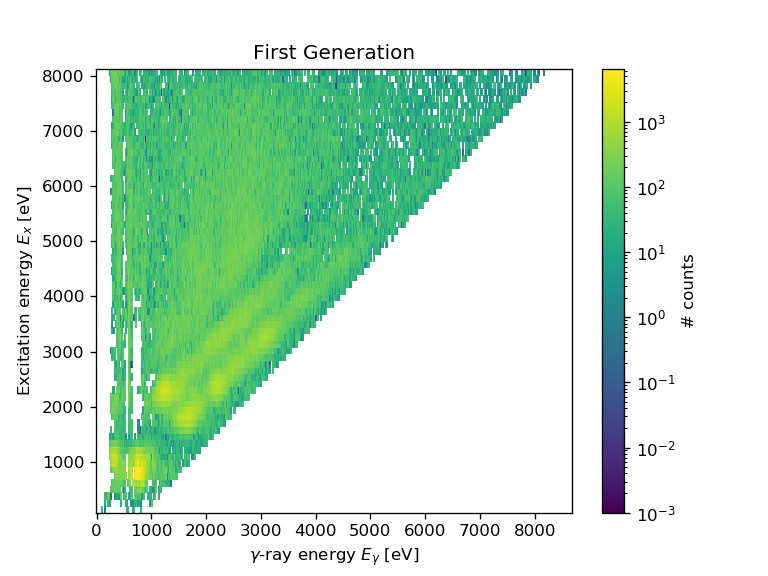

In [153]:
firstgen = om.first_generation_method(unfolded, Ex_max=8500, dE_gamma=500)
firstgen.fill_negative(window_size=10)
firstgen.remove_negative()
firstgen.plot(zmin=1e-3)

In [198]:
# Do error propagation in order to obtain an error matrix on the first generation spectrum
# Note that it requires an instance of MatrixAnalysis as input
logger = logging.getLogger("ompy.ensemble")
logger.setLevel(logging.INFO)

unfolder = om.Unfolder()
unfolder.cut_diagonal((800, 0), (7500, 7300))
unfolder.load_response(fname_resp_mat)

def firstmethod(U):
    return om.first_generation_method(matrix_in=U, Ex_max=8500,
                                     dE_gamma=800,multiplicity_estimation="statistical")
ensemble = om.Ensemble(raw=raw, save_path="error_ensemble")
ensemble.unfolder = unfolder
ensemble.first_generation_method = firstmethod
ensemble.generate(number=10, regenerate=True)


INFO:ompy.ensemble:Generating raw ensemble 0
INFO:ompy.ensemble:Unfolding raw 0
INFO:ompy.ensemble:Performing first generation on unfolded 0
INFO:ompy.ensemble:Generating raw ensemble 1
INFO:ompy.ensemble:Unfolding raw 1
INFO:ompy.ensemble:Performing first generation on unfolded 1
INFO:ompy.ensemble:Generating raw ensemble 2
INFO:ompy.ensemble:Unfolding raw 2
INFO:ompy.ensemble:Performing first generation on unfolded 2
INFO:ompy.ensemble:Generating raw ensemble 3
INFO:ompy.ensemble:Unfolding raw 3
INFO:ompy.ensemble:Performing first generation on unfolded 3
INFO:ompy.ensemble:Generating raw ensemble 4
INFO:ompy.ensemble:Unfolding raw 4
INFO:ompy.ensemble:Performing first generation on unfolded 4
INFO:ompy.ensemble:Generating raw ensemble 5
INFO:ompy.ensemble:Unfolding raw 5
INFO:ompy.ensemble:Performing first generation on unfolded 5
INFO:ompy.ensemble:Generating raw ensemble 6
INFO:ompy.ensemble:Unfolding raw 6
INFO:ompy.ensemble:Performing first generation on unfolded 6
INFO:ompy.ens

<IPython.core.display.Javascript object>


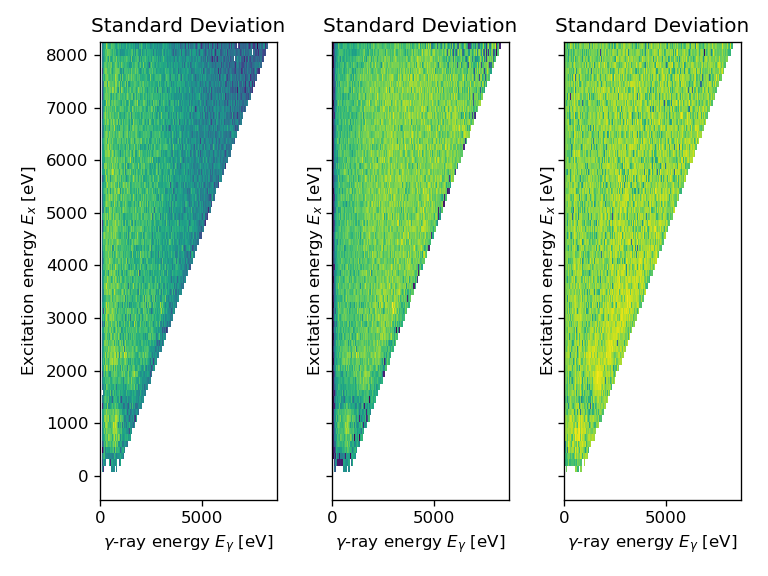

In [201]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ensemble.std_raw.plot(ax=ax[0])
ensemble.std_unfolded.plot(ax=ax[1])
ensemble.std_firstgen.plot(ax=ax[2])
plt.tight_layout()
plt.show()

In [170]:
# Fetch and plot the standard deviation of raw:
std_raw = ep.std_raw
std_raw.plot()

NameError: name 'ep' is not defined

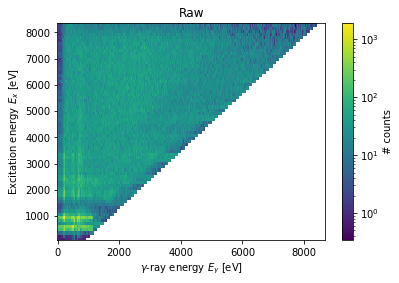

In [48]:
# Fetch and plot the standard deviation of firstgen:
std_firstgen = ep.std_firstgen
std_firstgen.plot()

attempt decomposition
Optimization terminated successfully.
         Current function value: 38952.871094
         Iterations: 9
         Function evaluations: 17157


True

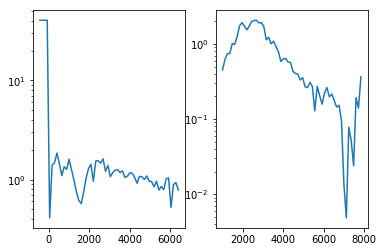

In [55]:
# Run fit to rho and T
# (This one needs some more bug testing...)

bin_width_out = 120
Ex_min = 3000
Ex_max = 8000
Eg_min = 1000


rho, T = om.fit_rho_T(ma.firstgen, std_firstgen,
                      bin_width_out,
                      Ex_min, Ex_max, Eg_min,
                      method="Nelder-Mead",
                     )


f, (axrho, axT) = plt.subplots(1,2)
rho.plot(ax=axrho, yscale="log")
T.plot(ax=axT, yscale="log")

rho (fitted) = [40.5390393  40.5390393  40.5390393  40.5390393   0.40948565  1.39843301
  1.47258934  1.8488843   1.45395147  1.09310303  1.34570813  1.26645346
  1.6024095   1.25739985  0.9904319   0.75783653  0.61408822  0.57218965
  0.74469044  1.02571931  1.28597197  1.42382713  0.9599367   1.54224022
  1.54552133  1.46241917  1.6155448   1.20912674  1.38692177  1.06955215
  1.17621558  1.24435919  1.25339842  1.17841898  1.22238583  1.04905026
  1.0797567   1.16659492  1.15704683  1.05376706  0.91726293  1.07491006
  1.06530715  1.00239405  1.08573543  0.96187049  0.95217527  0.84571499
  0.96197702  0.78373477  0.8493359   0.79047416  1.01080414  1.03965515
  0.52205612  0.88691834  0.93219026  0.78277745]
T (fitted) = [0.45130158 0.62344012 0.74090986 0.74675289 1.01663897 0.9846962
 1.24899022 1.7480542  1.91858449 1.7317991  1.54387263 1.72892266
 1.99250993 2.05202087 2.06810901 1.9054271  1.92100714 1.69876654
 1.13643918 1.2276945  1.00336871 1.09070414 0.92349294 0.7898265

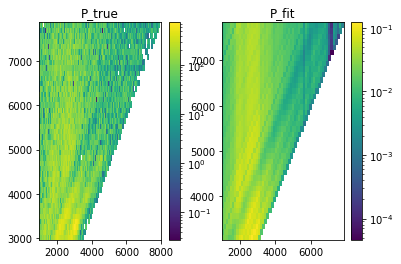

In [57]:
# Plot the experimental and fitted first-generation matrices:
# This plotting code is messy and should be cleaned up!
from matplotlib.colors import LogNorm

f2D, (ax_P_true, ax_P_fit) = plt.subplots(1, 2)
firstgen_cut = ma.firstgen.cut_rect(
                              axis="both",
                              E_limits=[Ex_min, Ex_max, Eg_min, Ex_max],
                              inplace=False
                              )
cbar = ax_P_true.pcolormesh(firstgen_cut.E1_array,
                            firstgen_cut.E0_array,
                            firstgen_cut.matrix,
                            norm=LogNorm())
ax_P_true.set_title("P_true")
f2D.colorbar(cbar, ax=ax_P_true)

# Run the cut just to get energy arrays for plotting (should be made nicer):
pars_fg = {"Egmin" : Eg_min,
           "Exmin" : Ex_min,
           "Emax" : Ex_max}
E_array_midbin = (om.E_array_from_calibration(a0=-500,
                                          a1=bin_width_out,
                                          E_max=Ex_max) 
                    + bin_width_out/2)
tmp, Emid_Eg, Emid_Ex, Emid_nld = om.fg_cut_matrix(ma.firstgen.matrix,
                                                        E_array_midbin, **pars_fg)

P_fit = om.PfromRhoT(rho.vector, T.vector, len(Emid_Ex),
                     Emid_Eg, Emid_nld, Emid_Ex)
cbar = ax_P_fit.pcolormesh(Emid_Eg, Emid_Ex, P_fit, norm=LogNorm())
ax_P_fit.set_title("P_fit")
f2D.colorbar(cbar, ax=ax_P_fit)

# P_diff = P_fit - P_true
# cbar = ax_P_diff.pcolormesh(E_array, E_array, P_diff)
# f2D.colorbar(cbar, ax=ax_P_diff)

# Print some quantities
# print("P_diff.max() =", P_diff.max())
print("rho (fitted) =", rho.vector)
print("T (fitted) =", T.vector)


plt.show()

# TODO: Add "does it work" plots...
(comparing P_true and P_fit, both normalized to unity, for single Ex bins as 1-D plots)